In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
import matplotlib.pyplot as plt
import numpy as np

In [24]:

TRAIN_PATH = "Plant Counting/train/train.tfrecord"
VALID_PATH = "Plant Counting/valid/valid.tfrecord"
TEST_PATH = "Plant Counting/test/test.tfrecord"

BATCH_SIZE = 32
EPOCHS = 50
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

In [25]:
data = tf.data.TFRecordDataset(TRAIN_PATH)

In [40]:
def decode_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    labels_sparse = example['image/object/class/label']
    labels_dense = tf.sparse.to_dense(labels_sparse, default_value=-1)
    label = tf.cast(tf.size(labels_dense), tf.float32)
    return image, label

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [41]:
train_ds = load_dataset(TRAIN_PATH)
valid_ds = load_dataset(VALID_PATH)
test_ds = load_dataset(TEST_PATH)

In [42]:
for raw_data in train_ds.take(1):
    print(raw_data)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.52697086, 0.6289116 , 0.4759904 ],
         [0.69517803, 0.7988195 , 0.5559624 ],
         [0.61950773, 0.7253901 , 0.44695875],
         ...,
         [0.4731105 , 0.4014021 , 0.3333347 ],
         [0.5633054 , 0.517307  , 0.4310325 ],
         [0.5995007 , 0.5765319 , 0.4821339 ]],

        [[0.5332133 , 0.635014  , 0.4822329 ],
         [0.72372943, 0.82737094, 0.5845138 ],
         [0.62613046, 0.72809124, 0.44965985],
         ...,
         [0.47112828, 0.40392143, 0.32549006],
         [0.4981595 , 0.44185707, 0.35866377],
         [0.5682072 , 0.5283717 , 0.44097662]],

        [[0.5555823 , 0.6503402 , 0.5009604 ],
         [0.77220887, 0.8671669 , 0.6282313 ],
         [0.6290716 , 0.72196877, 0.4465586 ],
         ...,
         [0.520208  , 0.46894753, 0.37623042],
         [0.6195884 , 0.56076485, 0.47056878],
         [0.6474171 , 0.6003583 , 0.50624067]],

        ...,

        [[0.47402987, 0.4541419 

In [43]:
base_model = applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


In [44]:

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3)

history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[early_stop, reduce_lr])


Epoch 1/50


     96/Unknown 65s 611ms/step - loss: 38.2396 - root_mean_squared_error: 6.1347

c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


96/96 ━━━━━━━━━━━━━━━━━━━━ 72s 692ms/step - loss: 38.1824 - root_mean_squared_error: 6.1304 - val_loss: 38.4559 - val_root_mean_squared_error: 6.2013 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 673ms/step - loss: 15.3627 - root_mean_squared_error: 3.8722 - val_loss: 19.2965 - val_root_mean_squared_error: 4.3928 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 844ms/step - loss: 10.4840 - root_mean_squared_error: 3.1857 - val_loss: 16.8112 - val_root_mean_squared_error: 4.1001 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 778ms/step - loss: 6.5999 - root_mean_squared_error: 2.5122 - val_loss: 16.6917 - val_root_mean_squared_error: 4.0855 - learning_rate: 0.0010
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - loss: 6.1070 - root_mean_squared_error: 2.4106 - val_loss: 15.1610 - val_root_mean_squared_error: 3.8937 - learning_rate: 0.0010
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - loss: 5.0725 - root_mean_squared_

In [45]:
results = model.evaluate(test_ds)
y_true = []
y_pred = []



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 87.5534 - root_mean_squared_error: 9.3570


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


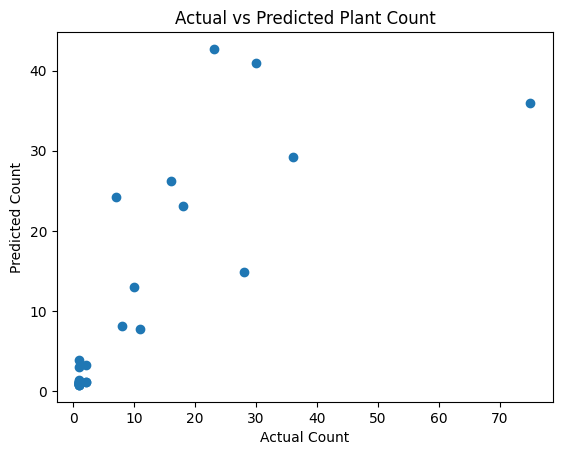

In [46]:
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

plt.scatter(y_true, y_pred)
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Plant Count')
plt.show()


In [47]:
rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
r2 = 1 - (np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(y_true)) ** 2))

print("Test RMSE:", rmse)
print("Test R²:", r2)



Test RMSE: 9.356998
Test R²: 0.636017918586731


In [ ]:

model.save('/kaggle/working/Plant_Counting_Upgraded_Model.keras')